Number of frames in sequence: 80


/home/rakib/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/rakib/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


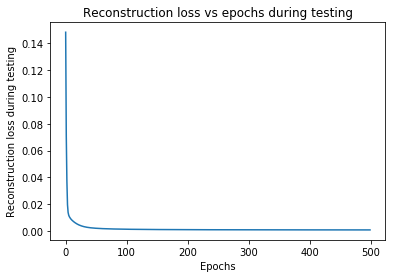

PSNR: 26.486134837418685


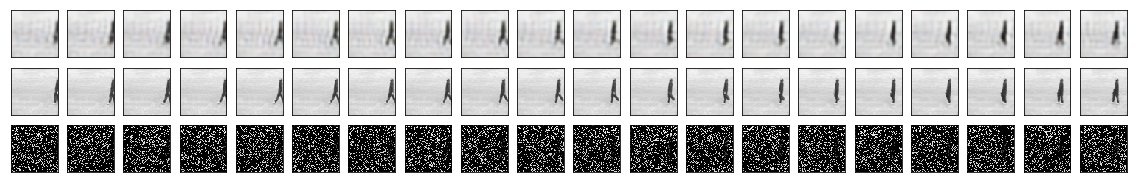

In [2]:
from glob import glob
from scipy import misc, linalg
import torch
from os.path import isfile, isdir
from os import mkdir
import numpy as np
import matplotlib.pyplot as plt
import skvideo.io

#You need to select the directory of the extracted frames.
#You need to select number of  channels, 1 for grayscaled, 3 for rgb
#You need to select initial weight of  the model, CIFAR10 for rgb, MNIST for grayscaled
#You can select measurement type
#You can select number of measurements or ratio of missing pixels
#You can select rank of the latent space
#You can select the method for applying low rank constraint 
#You can select initialization type of latent codes
#You can select weight on similarity constraint
#You can select if you need video output.
#You can select the name of the video output

# Sequence Directory
sequence_dir='data/walking/'
sequence_files=sorted(glob(sequence_dir+'*.jpg'))
sequence_size=len(sequence_files)
print('Number of frames in sequence: '+str(sequence_size))



init_model='model/CIFAR10_dcgan.pth'

z_dim=256  # Dimension of latent code
z_init='fixed_seed' # fixed_z, fixed_seed, random_seed
seed=100 # Used when fixed seed or fixed_z is selected
ngf = 64 # Height
ndf = 64 # Width
nc  = 3  # Channel

measurement_type='original' #'original', 'linear','missing'
num_measurements=512 # Used only for linear measurements
missing_ratio=0.8  # Used only for missing pixels
if measurement_type=='original':
    num_measurements=ngf*ndf*nc
elif measurement_type=='missing':      
    num_measurements=np.int(ngf*ndf*nc*(1-missing_ratio))
matrix_id=1

low_rank=0 # Can be at most max([z_dim,sequence_size]), If it is 0, then low rank constraint is not applied
low_rank_type='svd' #'svd': Select top r singular value; 'pca': Select mean and top r-1 pca components
lamda= 1 # Weight on similarity constraint, total loss= lamda* MSE+ (1-lamda)* similarity constraint

update_type='joint'#'latent','gen','joint'
test_size=sequence_size
test_epochs=500
test_batch_size=sequence_size

opt='sgd' #'sgd','adam'
if opt=='sgd':
    lr=1.0*test_batch_size/256
    alpha=200.0*test_batch_size/256
elif opt=='adam':
    lr=0.0001*test_batch_size/256
    alpha=200.0*test_batch_size/256
    
video_gen=1 # It will save the video sequence
video_name='video/walking'
if not isdir('video'):
    mkdir('video')

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
#Defining Generator class
class Generator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(    z_dim, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2,1, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
#            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = torch.nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output    
generator = Generator(1).to(device)

x_test=[]
for i in range (0,sequence_size):
    img=misc.imread(sequence_files[i])
    img=misc.imresize(img,[ngf,ndf])
    img=img/255.0
    temp=np.zeros((img.shape[2],img.shape[0],img.shape[1]))

    for chan in range (0,temp.shape[0]):
        temp[chan,:,:]=img[:,:,chan]
    x_test.append(temp)
x_test=np.array(x_test)

z_test=np.zeros((x_test.shape[0],z_dim))
if z_init=='fixed_seed':
    np.random.seed(seed)
for i in range (0,z_test.shape[0]): 
    if z_init=='fixed_z':
        np.random.seed(seed)
    z_test[i,:]=np.random.normal(loc=0, scale=1.0, size=(1,z_dim))
    z_test[i] = z_test[i, :] / np.linalg.norm(z_test[i, :], 2)
    
    
if isfile('/measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id)+'.npy'):
    A=np.load('/measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id)+'.npy')

elif measurement_type=='linear':
    A =np.random.normal(loc=0.0, scale=1.0/np.sqrt(num_measurements), size=(test_batch_size,num_measurements,nc*ngf*ndf))
    if not isdir('measurement_matrix'):
        mkdir('measurement_matrix')
    np.save('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id),A)
             
elif measurement_type=='missing':    
    A=np.ones((test_batch_size,nc,ngf,ndf))
    idx=np.arange(ngf*ndf)
    for i in range (0,test_batch_size):
        A_temp =np.ones((1,ngf*ndf))
        np.random.shuffle(idx)                
        A_temp[0,idx[0:np.int(ngf*ndf*missing_ratio)]]=0

        A_temp=np.reshape(A_temp,(ngf, ndf))
        A_c=np.zeros((ngf,ndf,nc))
        for j in range (0,nc):
            A_c[:,:,j]=A_temp            
        for j in range (0,nc):
            A[i,j,:,:]=A_c[:,:,j]
    if not isdir('measurement_matrix'):
        mkdir('measurement_matrix')
    np.save('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id),A)


x_test_org=x_test
if measurement_type=='linear':
    x_test=2*x_test-1
    x_test_temp=np.zeros((x_test.shape[0],num_measurements,1))
    for i in range (0, x_test.shape[0]):
        x_test_temp[i,:,:]=np.matmul(A[i%test_batch_size,:,:],x_test[i,:,:,:].reshape(1,nc*ngf*ndf,1))
    x_test=x_test_temp
elif measurement_type=='original': 
    x_test=2*x_test-1
    x_test=x_test  
elif measurement_type=='missing':
    x_test_temp=np.zeros((x_test.shape[0],nc,ngf,ndf))
    for i in range (0, x_test.shape[0]):
        x_test_temp[i,:,:]=np.multiply(x_test[i,:,:,:],A[i%test_batch_size,:,:,:])
    x_test=x_test_temp
    x_test=2*x_test-1

batch_no=np.int(np.ceil(test_size/np.float(test_batch_size)))
idx=np.arange(test_size)
loss_test=[]
loss_z_test=[]
x_rec=np.zeros((x_test.shape[0],nc,ngf,ndf))
for batch_idx in range(0,batch_no):
    generator.load_state_dict(torch.load(init_model))
    if opt=='sgd':
        optimizer = torch.optim.SGD(generator.parameters(), lr)
    elif opt=='adam':
        optimizer = torch.optim.Adam(generator.parameters(), lr)
    loss_epoch=[]
    loss_z_epoch=[]
    epoch_idx=idx
    
    if measurement_type=='original':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,:,:]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1,nc,ngf,ndf)
    elif measurement_type=='missing':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,:,:]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1,nc,ngf,ndf)
        A_tensor=torch.cuda.FloatTensor(A[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])]%test_batch_size,:,:]).view(-1,nc,ngf,ndf)
    elif measurement_type=='linear':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,0]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1, x_batch.shape[1],1)
        A_tensor=torch.cuda.FloatTensor(A[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])]%test_batch_size,:,:]).view(-1,num_measurements,nc*ngf*ndf)

    for epoch in range (0,test_epochs):

        z_batch=z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]
        z_batch_tensor=torch.autograd.Variable(torch.cuda.FloatTensor(z_batch).view(-1, z_dim, 1, 1),requires_grad=True)

        x_hat = generator(z_batch_tensor)
        if measurement_type=='linear':
            x_measure=torch.matmul(A_tensor,x_hat.view(-1, nc* ngf*ndf,1))
        elif measurement_type=='original':
            x_measure=x_hat
        elif measurement_type=='missing':
            x_hat_2=x_hat/2+0.5
            x_measure_1=torch.mul(x_hat_2,A_tensor)
            x_measure=2*x_measure_1-1

        loss_mse=(x_measure - x_batch_tensor).pow(2).mean()

        if test_batch_size>2:
            for i in range (0, np.int(np.ceil(z_batch.shape[0]/np.float(sequence_size)))):
                z_for=z_batch_tensor[i*sequence_size+1:np.min([(i+1)*sequence_size,test_batch_size]),:]
                z_back=z_batch_tensor[i*sequence_size:np.min([(i+1)*sequence_size,test_batch_size])-1,:]
                if i==0:
                    loss_z=(z_for-z_back).pow(2).mean()
                else:
                    loss_z=loss_z+(z_for-z_back).pow(2).mean()
            loss_z=loss_z

            loss=lamda*loss_mse+(1-lamda)*loss_z
        else:
            loss=lamda*loss_mse

        loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)   

        with torch.no_grad():        

            if update_type=='latent' or update_type=='joint':
                z_grad = z_batch_tensor.grad.data.cuda()
                z_update = z_batch_tensor - alpha * z_grad
                z_update = z_update.cpu().detach().numpy()
                z_update=np.reshape(z_update,z_batch.shape)
                if low_rank!=0:
                    if low_rank_type=='svd':
                        u, s, vh = np.linalg.svd(z_update, full_matrices=False)
                        z_update=np.dot(u * np.append(s[0:low_rank],np.zeros(len(s)-low_rank)), vh)
                    elif low_rank_type=='pca':
                        z_mean=np.mean(z_update,axis=0)
                        z_temp=z_update-z_mean
                        u, s, vh = np.linalg.svd(z_temp, full_matrices=False)
                        z_new=np.dot(u * np.append(s[0:low_rank-1],np.zeros(len(s)-low_rank+1)), vh)
                        z_update=z_new+z_mean
                z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]=z_update
                
        if update_type=='gen' or update_type=='joint':
            optimizer.zero_grad()
            loss.backward()   
            optimizer.step()
            
        z_update_tensor=torch.autograd.Variable(torch.cuda.FloatTensor(z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]).view(-1, z_dim, 1, 1))    
        x_hat = generator(z_update_tensor)
        x_rec[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]=np.reshape(x_hat.cpu().detach().numpy(),(x_batch.shape[0],nc,ngf,ndf))

    loss_test .append(np.array(loss_epoch))
    
plt.figure()
plt.plot(np.mean(np.array(loss_test),axis=0))  
plt.xlabel('Epochs')
plt.ylabel('Reconstruction loss during testing')
plt.title('Reconstruction loss vs epochs during testing')    
plt.show()

x_rec=x_rec/2+0.5
mse=np.mean((x_rec-x_test_org)**2)
psnr=20*np.log10((np.max(x_test_org)-np.min(x_test_org))/np.sqrt(mse))
print('PSNR: ' +str(psnr))

corrupt=0
if measurement_type=='missing':
    corrupt=1
start_fig=0
n=20    
plt.figure(figsize=(n, 2+corrupt))

for i in range(n):
    # display original
    if nc==1:
        # Plot reconstruction
        ax = plt.subplot(2+corrupt, n, i + 1)
        plt.imshow(x_rec[i+start_fig].reshape(ngf, ndf))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot original
        ax = plt.subplot(2+corrupt, n, i + 1+1*n)
        plt.imshow(x_test_org[i+start_fig].reshape(ngf, ndf))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if corrupt==1:
            # Plot inpainted
            ax = plt.subplot(2+corrupt, n, i + 1+2*n)
            plt.imshow((x_test[i+start_fig]/2+0.5).reshape(ngf, ndf))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    elif nc==3:
        # Plot reconstruction
        ax = plt.subplot(2+corrupt, n, i + 1)
        temp=x_rec[i+start_fig]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        plt.imshow(temp1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Plot original
        ax = plt.subplot(2+corrupt, n, i + 1+1*n)
        temp=x_test_org[i+start_fig]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        plt.imshow(temp1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if corrupt==1:
            # Plot inpainted
            ax = plt.subplot(2+corrupt, n, i + 1+2*n)
            temp=x_test[i+start_fig]/2+0.5
            temp1=np.zeros((ngf, ndf,nc))
            for chan in range (0,nc):
                temp1[:,:,chan]=temp[chan,:,:]
            plt.imshow(temp1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            
if video_gen==1:
    outputdata = x_test_org * 255
    outputdata = outputdata.astype(np.uint8)
    x_test_vid=np.zeros((outputdata.shape[0],ngf, ndf,nc))
    for i in range(0,outputdata.shape[0]):
        temp=outputdata[i]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        x_test_vid[i]=temp1
    writer = skvideo.io.FFmpegWriter(video_name+'_true_resize'+str(ngf)+'.mp4')
    for i in xrange(x_test_vid.shape[0]):
            writer.writeFrame(x_test_vid[i, :, :, :])
    writer.close()

    outputdata = x_rec * 255
    outputdata = outputdata.astype(np.uint8)
    x_test_vid=np.zeros((outputdata.shape[0],ngf, ndf,nc))
    for i in range(0,outputdata.shape[0]):
        temp=outputdata[i]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        x_test_vid[i]=temp1
    writer = skvideo.io.FFmpegWriter(video_name+'_rec_resize'+str(ngf)+measurement_type+str(num_measurements)+'.mp4')
    for i in xrange(x_test_vid.shape[0]):
            writer.writeFrame(x_test_vid[i, :, :, :])
    writer.close()

    if corrupt==1:
        outputdata = (x_test/2+0.5) * 255
        outputdata = outputdata.astype(np.uint8)
        x_test_vid=np.zeros((outputdata.shape[0],ngf, ndf,nc))
        for i in range(0,outputdata.shape[0]):
            temp=outputdata[i]
            temp1=np.zeros((ngf, ndf,nc))
            for chan in range (0,nc):
                temp1[:,:,chan]=temp[chan,:,:]
            x_test_vid[i]=temp1
        writer = skvideo.io.FFmpegWriter(video_name+'_inpainted_resize'+str(ngf)+measurement_type+str(num_measurements)+'.mp4')
        for i in xrange(x_test_vid.shape[0]):
                writer.writeFrame(x_test_vid[i, :, :, :])
        writer.close()

if low_rank==2:        
    zt=z_test
    u, s, vh = np.linalg.svd(zt, full_matrices=False)
    zt=np.dot(u * np.append(s[0:low_rank],np.zeros(len(s)-low_rank)), vh)

    zb=linalg.orth(zt.T)
    zb=zb.T
    a1=np.matmul(zt[0:sequence_size,:],np.linalg.pinv(zb))
    area=50
    plt.figure()
    start_seq=0
    end_seq=sequence_size  
    ax=plt.subplot()
    plt.scatter(a1[start_seq:end_seq,0], a1[start_seq:end_seq,1],s=area,alpha=1)
    plt.grid(True)
    plt.xlabel('Weight on orthogonal basis 1')
    plt.ylabel('Weight on orthogonal basis 2')
    plt.title('2D Representation of Latent Codes')
    for i in range(a1.shape[0]):
        ax.annotate('  '+str(i+1), (a1[i,0], a1[i,1]))  

        